<a href="https://colab.research.google.com/github/WuzI38/Data/blob/main/MidiGenFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Generation with LSTM neural network - in progress

## Download data

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download programgeek01/anime-music-midi

100% 707k/707k [00:00<00:00, 892kB/s]
100% 707k/707k [00:00<00:00, 892kB/s]


In [ ]:
# Debug
!pip install -Uqq ipdb --use-deprecated=legacy-resolver
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 KB 19.7 MB/s eta 0:00:00
ERROR: pip's legacy dependency resolver does not consider dependency conflicts when selecting packages. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you'll have ipython 8.11.0 which is incompatible.


In [ ]:
# Unzip data
import zipfile

zip_ref = zipfile.ZipFile("anime-music-midi.zip", "r") # Hey, don't blame me for the name, I am not this dataset's creator
zip_ref.extractall()
zip_ref.close()

In [ ]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# enables playing midi files
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

# Copy soundfont to content directory
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

installing lilypond...
Extracting templates from packages: 100%
installing fluidsynth...


## Loading and preprocessing

### Parsing files

In [ ]:
import os
from music21 import *
from fractions import Fraction

path = "/content/data/undertale/"
midi_list = []
for filename in os.listdir(path):
  # print(filename)
  parsed_file = converter.parse(path + filename)
  midi_list.append(parsed_file)

### Extracting notes and chords
After analysing the data for some time I've noticed some important things:
* All notes have length of x/12, where x is a natural number
* Some notes have the same offset as others, so they must be removed 
* Some notes have offsets less than the offset of the preceding + the length of the preceding note, thus the preceding notes must be trimmed to create sequence

In [ ]:
import music21
def fragmentise(midi_stream: music21.stream.Score) -> list:
  return [part.flat.notes for part in midi_stream.parts]

In [ ]:
# Part one - extract notes from both streams and save them into a list
def get_all_notes(midi_piece: music21.stream.Score) -> list:
  all_notes = list()
  note_types = set()
  midi_part = fragmentise(midi_piece)[0] # use only notes that belong to main melody
  for nt in midi_part.flat.notes: 
    if isinstance(nt, note.Note):
      pitch = str(max(0.0, nt.pitch.ps))
    elif isinstance(nt, chord.Chord):
      pitch = sorted([str(max(0.0, n.ps)) for n in nt.pitches])
      pitch = ' '.join(pitch)
    ql = nt.duration.quarterLength
    if len(all_notes) > 0: 
      if nt.offset == all_notes[-1][0]: # Remove notes with the same offset as others
        continue
      if all_notes[-1][0] + all_notes[-1][2] > nt.offset: # Trim longer notes to retain the sequence
        all_notes[-1][2] = nt.offset - all_notes[-1][0]
      
    all_notes.append([nt.offset, pitch, ql if ql > 0.0 else 0.25]) # If for some reason len is 0 replace it with 0.25
  return all_notes

In [ ]:
notes_list = get_all_notes(midi_list[1])
notes_list[:10]

[[0.0, '54.0', 0.5],
 [0.5, '61.0', 0.5],
 [1.0, '57.0', 1.0],
 [2.0, '56.0', 0.5],
 [2.5, '57.0', 0.5],
 [3.0, '59.0', 1.0],
 [5.5, '52.0', 0.5],
 [6.0, '54.0', 0.5],
 [6.5, '61.0', 0.5],
 [7.0, '57.0', 1.0]]

In [ ]:
# Part 2 extract all chord types from the dataset
import numpy as np

types = dict()
types_sorted = dict()
for d in midi_list:
  notes_list = np.array(get_all_notes(d))
  strings = notes_list[:, 1]
  for s in strings:
    types[s] = 1 + types[s] if types.get(s) is not None else 1
    if types_sorted.get(s) is None:
      types_sorted[s] = int(s[:s.find('.')])

In [ ]:
# Maybe sorting keys will help lstm find relations between pitches after encoding (I'm not sure)
types_sorted = {k: v for k, v in sorted(types_sorted.items(), key=lambda item: item[1])}
types = {k: types[k] for k in types_sorted.keys()}

In [ ]:
print(len(types))

1809


### Removing rare chords

In [ ]:
# Counting notes
chord_counts = dict()
for item in sorted(list(types.values())):
  chord_counts[str(item)] = 1 + chord_counts[str(item)] if chord_counts.get(str(item)) is not None else 1

chord_counts = {k: v for k, v in chord_counts.items() if v > 1}

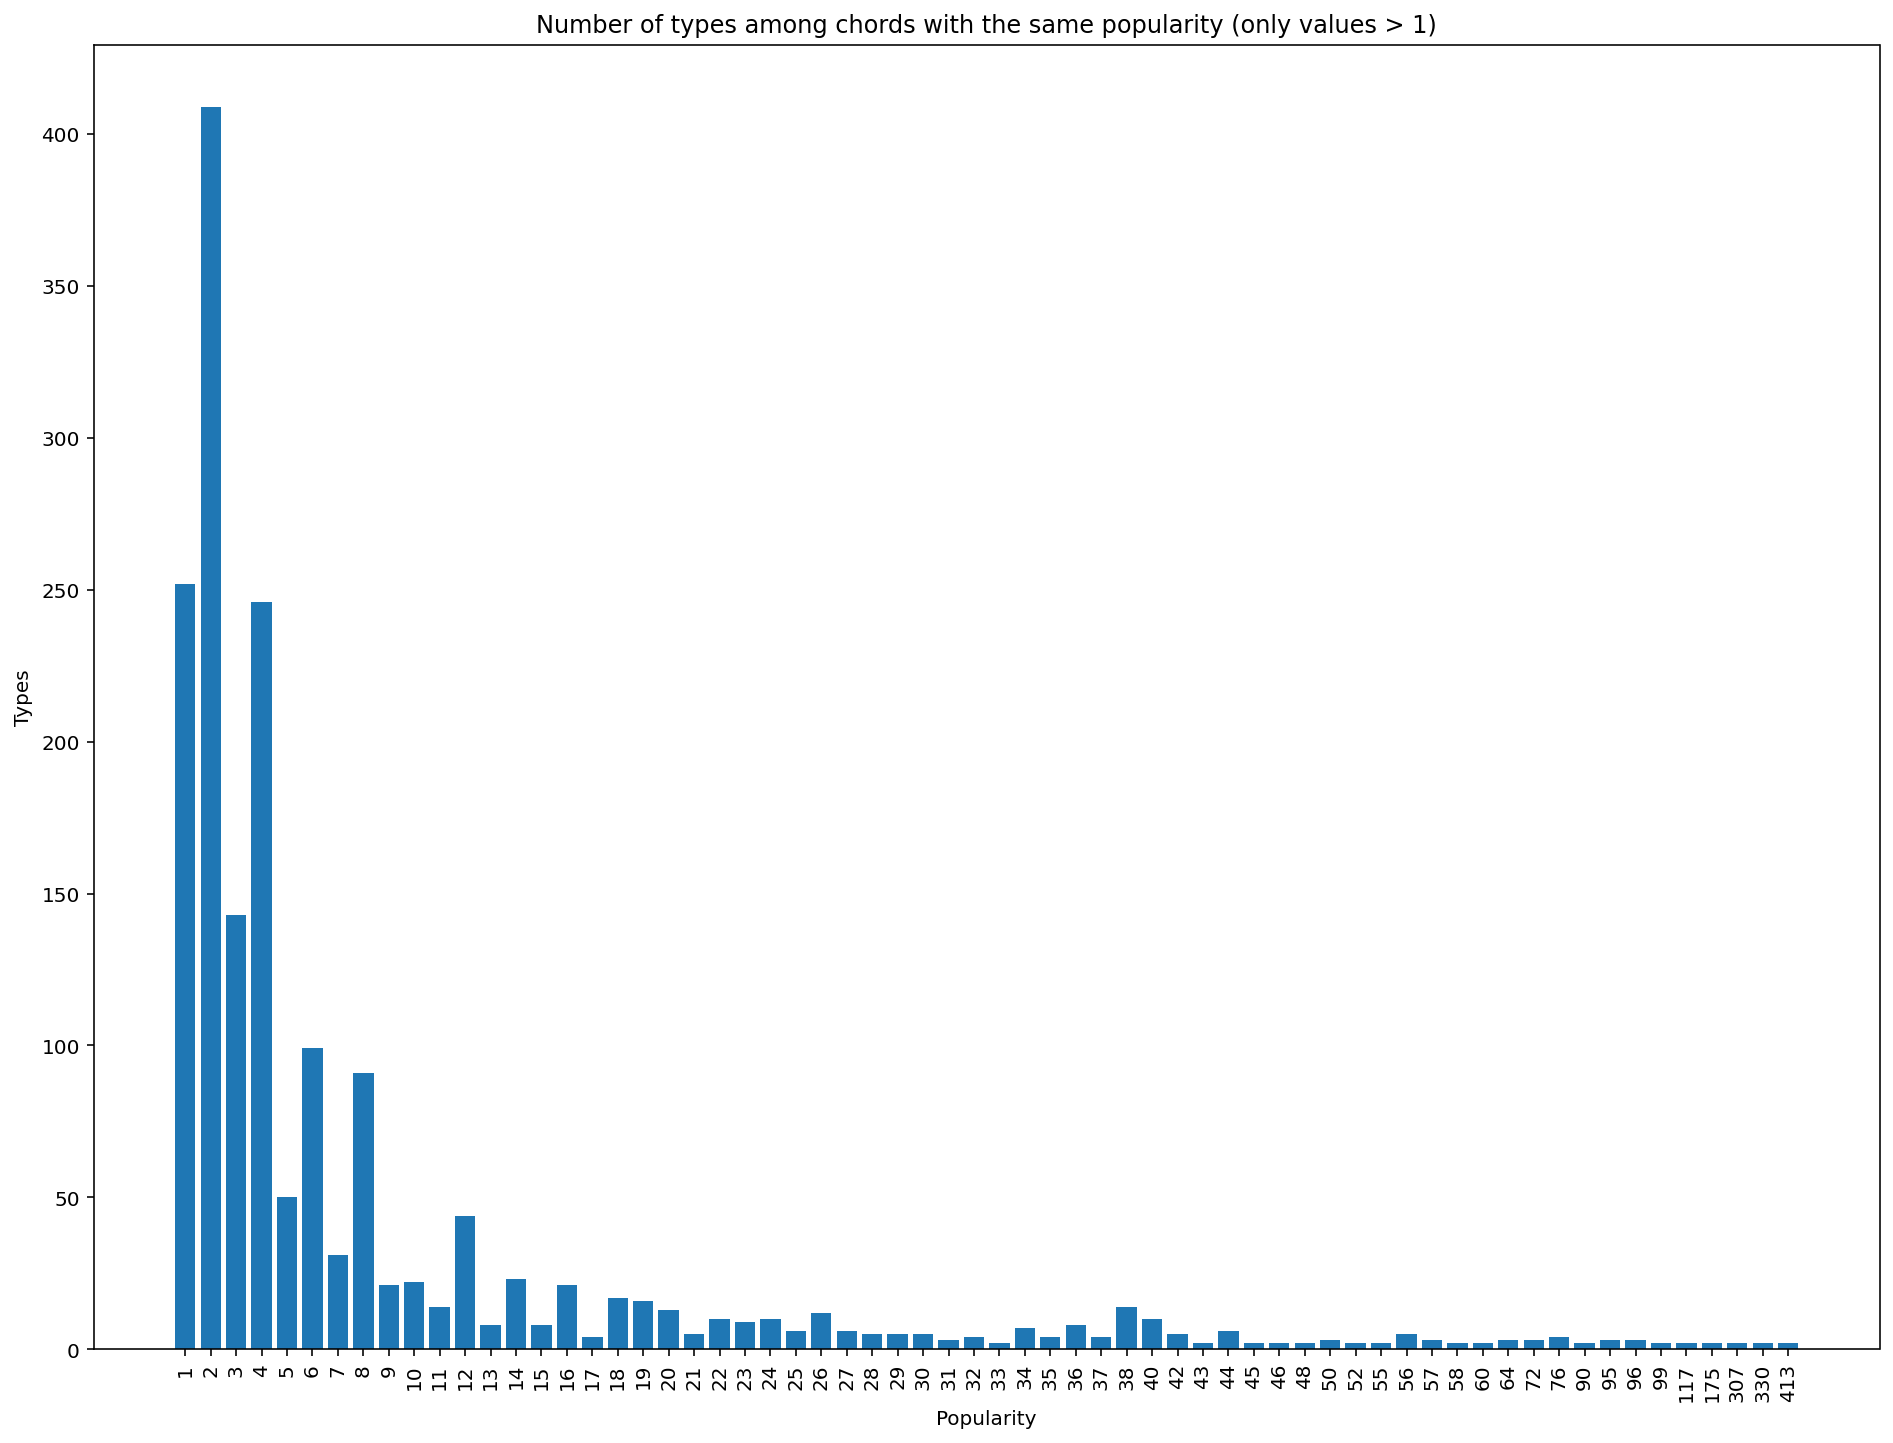

In [ ]:
# Plotting the values
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary as lists
keys = list(chord_counts.keys())
values = list(chord_counts.values())

# Change size
plt.figure(figsize=(16, 12))

# Create a bar chart using the plot function
plt.bar(keys, values)

# Add a title and axis labels
plt.title('Number of types among chords with the same popularity (only values > 1)')
plt.xlabel('Popularity')
plt.ylabel('Types')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [ ]:
from statistics import mean
HOW_MANY = 20
means = [mean([len(k)//4 for k, v in types.items() if v <= i]) for i in range(1, HOW_MANY + 1)]

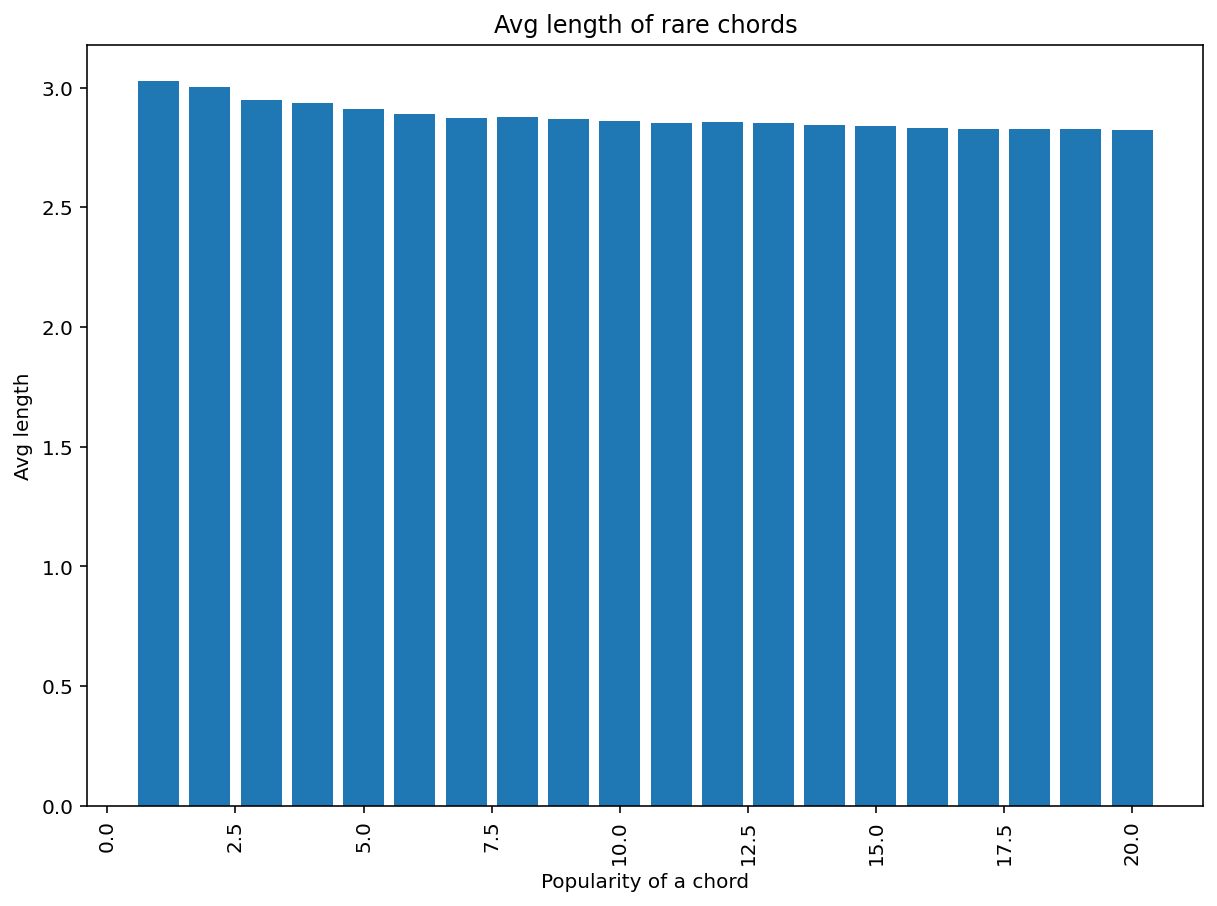

In [ ]:
# Plotting the means
plt.figure(figsize=(10, 7))

# Create a bar chart using the plot function
plt.bar(list(range(1, HOW_MANY + 1)), means)

# Add a title and axis labels
plt.title('Avg length of rare chords')
plt.xlabel('Popularity of a chord')
plt.ylabel('Avg length')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

The avg length is around 3 for the rare chords, so I can probably shorten them to 2 notes for the encoding purposes, so i don't have to use 1881 different values

## Visualization

In [ ]:
import music21
from IPython.display import Image, Audio

def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
    try:
        filename = music.write('mid')
        os.system(f'fluidsynth -ni font.sf2 {filename} -F {filename}.wav -r 16000 > /dev/null')
        display(Audio(f'{filename}.wav'))
    except Exception as e:
        print(f'Error: {e}')

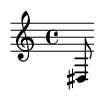

In [ ]:
n = music21.note.Note('D#3')
n.duration = duration.Duration(Fraction(1, 3))
show(n)

In [ ]:
play(n)

In [ ]:
from music21 import chord
def create_midi_part(melody: list) -> list:
  melody_ready = []
  # Create really ugly and unnecessary for loop just for 
  for sound in melody:
    if len(sound[1]) <= 4:
      new_note = note.Note(int(float(sound[1])), quarterLength = sound[2]) # use .nameWithOctave for the names only
    else:
      pitches_str = sound[1].split()
      pitches = [int(float(s)) for s in pitches_str]
      new_note = chord.Chord(pitches, quarterLength = sound[2]) # Must be an int (despite the fact that GPT says otherwise)
    new_note.offset = sound[0]
    melody_ready.append(new_note)
  return melody_ready

In [ ]:
melody_visual = create_midi_part(get_all_notes(midi_list[1]))
melody_midi = stream.Stream(melody_visual)

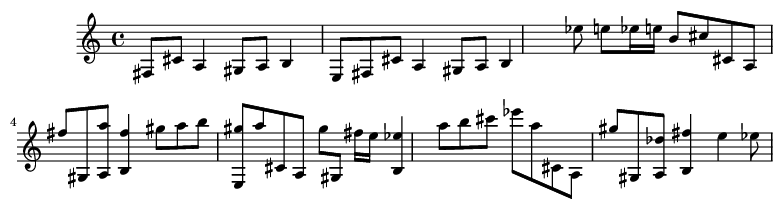

In [ ]:
show(melody_midi[:50])

In [ ]:
play(melody_midi[:100])

## Simpifying chords and encoding

In [ ]:
LIMIT = 21 # Rare chord is shorter or equal to limit
TRIM_TO = 9 # Reduces rare chords to 2 notes
TRIM_TO = TRIM_TO if (TRIM_TO - 4) % 5 == 0 else 9 # Choose correct trim
REMOVE_PAUSES = True # Remove pauses (encoded as 0 by default) from the encoded piece
# Pauses create problems during dataset windowing

In [ ]:
### Check if removing rare chords helps
ENCODER = dict() # checking if trimming chords makes any sense at all + creating id for each chord
TRIMMER = dict() # enables transformation of chords
id = 1
for key, value in types.items(): 
  kcp = key[:TRIM_TO] if value <= LIMIT and len(key) > TRIM_TO else key
  TRIMMER[key] = kcp
  if ENCODER.get(kcp) is None:
    ENCODER[kcp] = id
    id += 1

print(len(types), len(ENCODER))

1809 1142


### Encoding and decoding

In [ ]:
notes_list[:10]

array([[0.0, '62.0', 0.25],
       [0.25, '62.0', 0.25],
       [0.5, '74.0', 0.25],
       [1.0, '69.0', 0.25],
       [1.75, '68.0', 0.25],
       [2.25, '67.0', 0.25],
       [2.75, '65.0', 0.5],
       [3.25, '62.0', 0.25],
       [3.5, '65.0', 0.25],
       [3.75, '67.0', 0.25]], dtype=object)

In [ ]:
# Warning!!! This method removes rare chords, so the encoded version may not be the same
# Pause id -> pause

def encode_part(notes: list, chord_trans: dict, chords_id: dict, pause_id: int = 0) -> list:
  sound_list = list()
  length_list = list()
  for index, value in enumerate(notes[:-1]):
    # Calculate len of the note and offset difference between notes
    ln = int(value[2] * 12)
    if ln <= 0: # For some reason I still have notes of length 0 in my array
      continue
    offset_dif = int(12 * (notes[index + 1][0] - value[0]))
    # Encode note/chord and add it to respective list
    new_symbol = chords_id[chord_trans[value[1]]]
    sound_list.append(new_symbol)
    length_list.append(ln)
    # If there is a pause after a note add pause_id to sound_list
    if ln < offset_dif:
      sound_list.append(pause_id)
      length_list.append(offset_dif - ln)

  new_symbol = chords_id[chord_trans[value[1]]]
  sound_list.append(new_symbol)
  length_list.append(ln)
    
  return sound_list, length_list

In [ ]:
notes, lens = encode_part(get_all_notes(midi_list[1]), TRIMMER, ENCODER)
notes[:20], lens[:20]

([650,
  799,
  725,
  697,
  725,
  764,
  0,
  602,
  650,
  799,
  725,
  697,
  725,
  764,
  1015,
  1028,
  1015,
  1028,
  968,
  993],
 [6, 6, 12, 6, 6, 12, 18, 6, 6, 6, 12, 6, 6, 12, 6, 6, 3, 3, 6, 6])

In [ ]:
# Transform notes of len 1/3 into python fractions
def float_to_fraction(x: float):
    frac = Fraction(x).limit_denominator()
    return frac if (frac.denominator % 3 == 0 and frac.numerator % frac.denominator != 0) else x

print(float_to_fraction(0.25), float_to_fraction(0.3333333333333))

0.25 1/3


In [ ]:
def decode_part(notes: list, lenghts: list, chords_id_encoder: dict, empty_id: int = 1, pause_id: int = 0) -> list:
  offset = 0
  notes_decoded = list()
  for z in zip(notes, lenghts):
    if z[0] != pause_id:
      notes_decoded.append([offset, chords_id_encoder[z[0]], float_to_fraction(z[1] / 12)])
    offset += float_to_fraction(z[1] / 12)
  return notes_decoded

In [ ]:
# Create decoder dictionary
DECODER = {v: k for k, v in ENCODER.items()}

In [ ]:
notes_dec = decode_part(notes, lens, DECODER)
notes_dec[:10]

[[0, '54.0', 0.5],
 [0.5, '61.0', 0.5],
 [1.0, '57.0', 1.0],
 [2.0, '56.0', 0.5],
 [2.5, '57.0', 0.5],
 [3.0, '59.0', 1.0],
 [5.5, '52.0', 0.5],
 [6.0, '54.0', 0.5],
 [6.5, '61.0', 0.5],
 [7.0, '57.0', 1.0]]

## Windowing and creating train-test split

### Windowing

In [ ]:
# Predict one note/pause using 8 preceding notes, train-test split = 80%
HORIZON = 1
WINDOW_SIZE = 8
TRAIN_TEST = 0.8
MIN_PIECE_LEN = WINDOW_SIZE + HORIZON

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x: np.ndarray, horizon=12):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
def make_windows(x: np.ndarray, window_size: int = WINDOW_SIZE, horizon: int = HORIZON, step: int = None) -> np.ndarray:
  # 0. By default step == window_size
  step = horizon if step is None else step

  # 1. Create a window of specific window size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Use numpy indexing to create a 2D array of multiple windows
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).transpose()
  # len(x)-(window_size+horizon-1) is used to prevent sliding window from getting out of range
  # Basically for some reason the sum of [[0, 1, 2]] and [[0], [1], [2]] gives you [[0, 1, 2], [1, 2, 3], [2, 3, 4]]

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Divide widowed data
  if step > 1:
    windowed_array = windowed_array[::step]

  # 5. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
test_windows, test_labels = make_windows(np.array(notes), window_size = WINDOW_SIZE, horizon = HORIZON)

In [ ]:
test_windows[:3]

array([[650, 799, 725, 697, 725, 764,   0, 602],
       [799, 725, 697, 725, 764,   0, 602, 650],
       [725, 697, 725, 764,   0, 602, 650, 799]])

In [ ]:
test_labels[:2]

array([[650],
       [799]])

### Joining encoded midis

In [ ]:
X_set_notes = None
y_set_notes = None
X_set_lens = None
y_set_lens = None
  
for midi in midi_list:
  notes_full = get_all_notes(midi)
  if len(notes_full) < MIN_PIECE_LEN:
    continue

  notes_encoded, lens_encoded = encode_part(notes_full, TRIMMER, ENCODER)

  windows_notes, labels_notes = make_windows(np.array(notes_encoded), 
                                   window_size = WINDOW_SIZE, 
                                   horizon = HORIZON)
  
  windows_lens, labels_lens = make_windows(np.array(lens_encoded), 
                                   window_size = WINDOW_SIZE, 
                                   horizon = HORIZON)

  if X_set_notes is None:
    X_set_notes = windows_notes
    y_set_notes = labels_notes
    X_set_lens = windows_lens
    y_set_lens = labels_lens
  else:
    X_set_notes = np.concatenate([X_set_notes, windows_notes])
    y_set_notes = np.concatenate([y_set_notes, labels_notes])
    X_set_lens = np.concatenate([X_set_lens, windows_lens])
    y_set_lens = np.concatenate([y_set_lens, labels_lens])

In [ ]:
len(X_set_notes), len(y_set_notes), len(X_set_lens), len(y_set_lens)

(50949, 50949, 50949, 50949)

In [ ]:
np.unique(X_set_lens)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  18,  20,  21,  24,  25,  27,  28,  30,  36,  38,
        42,  43,  44,  45,  47,  48,  51,  57,  60,  61,  69,  72,  84,
        91,  93,  96,  99, 108, 132, 139, 150, 176, 180, 192, 196, 207,
       210])

In [ ]:
np.unique(X_set_notes)

array([   0,    2,    3, ..., 1140, 1141, 1142])

### Train-test split

In [ ]:
divider = int(len(X_set_notes) * TRAIN_TEST)

X_set_notes_train = X_set_notes[:divider]
X_set_notes_test = X_set_notes[divider:]
y_set_notes_train = y_set_notes[:divider]
y_set_notes_test = y_set_notes[divider:]
X_set_lens_train = X_set_lens[:divider]
X_set_lens_test = X_set_lens[divider:]
y_set_lens_train = y_set_lens[:divider]
y_set_lens_test = y_set_lens[divider:]

In [ ]:
len(X_set_notes_train), len(X_set_notes_test)

(40759, 10190)

In [ ]:
print(f"Notes_X:\n {X_set_notes_train[:5]}\n\n", 
      f"Notes_y:\n {y_set_notes_train[:5]}\n\n", 
      f"Lens_X:\n {X_set_lens_train[:5]}\n\n", 
      f"Lens_y:\n {y_set_lens_train[:5]}")

Notes_X:
 [[ 799  872    0 1015 1064  781  836    0]
 [ 872    0 1015 1064  781  836    0 1080]
 [   0 1015 1064  781  836    0 1080 1080]
 [1015 1064  781  836    0 1080 1080  836]
 [1064  781  836    0 1080 1080  836    0]]

 Notes_y:
 [[1080]
 [1080]
 [ 836]
 [   0]
 [ 743]]

 Lens_X:
 [[6 3 9 3 3 6 3 3]
 [3 9 3 3 6 3 3 3]
 [9 3 3 6 3 3 3 3]
 [3 3 6 3 3 3 3 3]
 [3 6 3 3 3 3 3 3]]

 Lens_y:
 [[3]
 [3]
 [3]
 [3]
 [6]]


First try: no one hot encoding (memory complexity issues + capturing relations between different lengths)  



## LSTM
I was wandering if using concatenate layer would be a good idea, but ultimately I chose simpler approach

### Model layout

In [ ]:
from tensorflow.keras import layers
from tensorflow import expand_dims
import tensorflow as tf

tf.random.set_seed(91)

In [ ]:
X_set_notes_train.shape, y_set_notes_train.shape

((40759, 8), (40759, 1))

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [ ]:
x = tf.constant(X_set_notes_train[0])
x.shape, expand_dims_layer(x).shape

(TensorShape([8]), TensorShape([8, 1]))

LSTM - notes

In [ ]:
input_notes = layers.Input(shape=(WINDOW_SIZE), dtype=tf.float32)

x_notes = expand_dims_layer(input_notes)
x_notes = layers.LSTM(128, activation="relu")(x_notes)
x_notes = layers.Dense(32, activation="relu")(x_notes)
output_notes = layers.Dense(HORIZON)(x_notes)

model_notes = tf.keras.Model(inputs = input_notes, outputs = output_notes, name="model_notes")

LSTM_2 - lengths

In [ ]:
input_lens = layers.Input(shape=(WINDOW_SIZE), dtype=tf.float32)

x_lens = expand_dims_layer(input_lens)
x_lens = layers.LSTM(128, activation="relu")(x_lens)
x_lens = layers.Dense(32, activation="relu")(x_lens)
output_lens = layers.Dense(HORIZON)(x_lens)

model_lens = tf.keras.Model(inputs = input_lens, outputs = output_lens, name="model_lens")

In [ ]:
model_notes.summary()

Model: "model_notes"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8)]               0         
                                                                 
 lambda (Lambda)             (None, 1, 8)              0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               70144     
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74,305
Trainable params: 74,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lens.summary()

Model: "model_lens"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8)]               0         
                                                                 
 lambda (Lambda)             (None, 1, 8)              0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               70144     
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74,305
Trainable params: 74,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
model_notes.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

history_lstm_notes = model_notes.fit(x=X_set_notes_train, 
                                     y=y_set_notes_train,
                                     epochs=100,
                                     verbose=0,
                                     batch_size=128,
                                     validation_data=(X_set_notes_test, y_set_notes_test))

CPU times: user 4min 24s, sys: 22 s, total: 4min 46s
Wall time: 4min 23s


In [ ]:
%%time
model_lens.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

history_lstm_lens = model_lens.fit(x=X_set_lens_train, 
                                     y=y_set_lens_train,
                                     epochs=100,
                                     verbose=0,
                                     batch_size=128,
                                     validation_data=(X_set_lens_test, y_set_lens_test))

CPU times: user 4min 30s, sys: 23 s, total: 4min 53s
Wall time: 4min 23s


### Learning curves

In [ ]:
import seaborn as sns
import pandas as pd

[Text(0.5, 0, 'Epochs')]

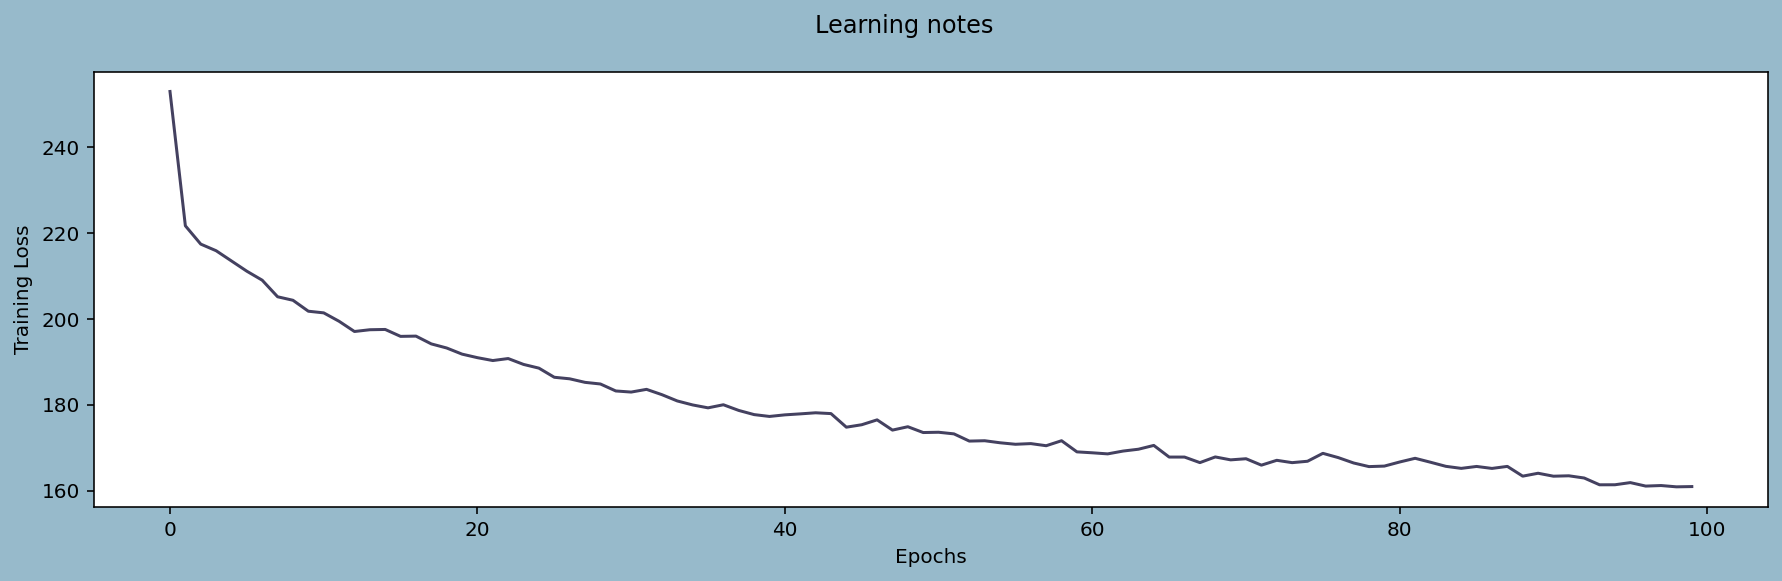

In [ ]:
history_df = pd.DataFrame(history_lstm_notes.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning notes")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [ ]:
history_df

loss         mae            mse    val_loss     val_mae  \
0   252.999161  252.999161  125272.593750  233.465851  233.465851   
1   221.696930  221.696930  110281.843750  233.394943  233.394943   
2   217.429062  217.429062  106854.273438  232.962097  232.962097   
3   215.888474  215.888474  106246.421875  236.801712  236.801712   
4   213.500381  213.500381  107006.828125  235.410675  235.410675   
..         ...         ...            ...         ...         ...   
95  161.845154  161.845154   76945.929688  241.206741  241.206741   
96  161.033676  161.033676   76283.132812  241.089111  241.089111   
97  161.161621  161.161621   76532.617188  239.897644  239.897644   
98  160.859222  160.859222   76207.835938  242.044388  242.044388   
99  160.920761  160.920761   76486.414062  240.234985  240.234985   

          val_mse  
0   115236.625000  
1   114094.492188  
2   113511.781250  
3   116614.648438  
4   119067.421875  
..            ...  
95  127431.382812  
96  128124.546875  
97  125683.679688  
98  128875.234375  
99  127309.289062  

[100 rows x 6 columns]

[Text(0.5, 0, 'Epochs')]

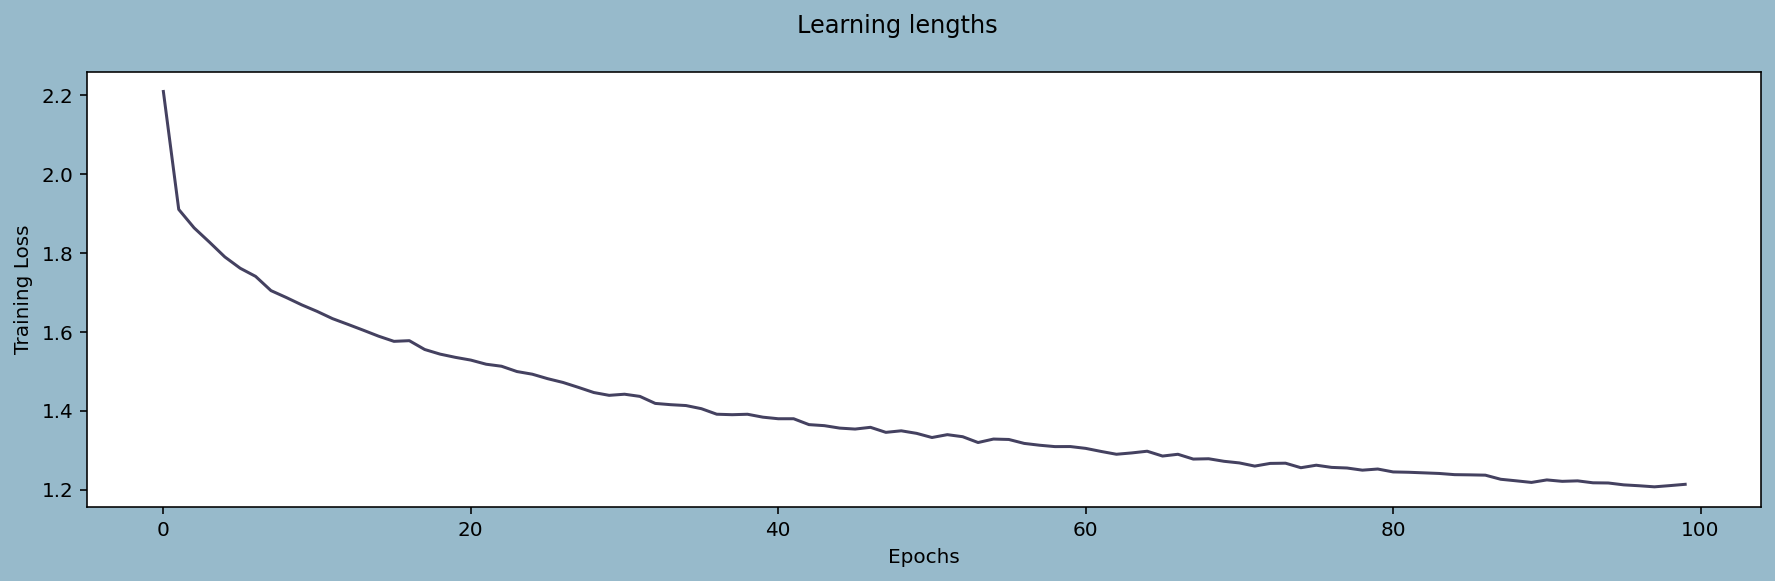

In [ ]:
history_df = pd.DataFrame(history_lstm_lens.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning lengths")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

It turns out my model is learning nothing new...

In [ ]:
history_df

loss       mae        mse  val_loss   val_mae    val_mse
0   2.209757  2.209757  27.008038  1.726489  1.726489  40.221851
1   1.910575  1.910575  24.763491  1.726254  1.726254  40.191605
2   1.863787  1.863787  24.099976  1.768886  1.768886  39.434395
3   1.827490  1.827490  23.657698  1.680652  1.680652  39.543171
4   1.790016  1.790016  23.200535  1.682093  1.682093  38.770386
..       ...       ...        ...       ...       ...        ...
95  1.211889  1.211889  16.070559  1.744006  1.744006  43.916416
96  1.209623  1.209623  15.935677  1.756142  1.756142  43.454582
97  1.206877  1.206877  15.942737  1.753555  1.753555  43.570801
98  1.209963  1.209963  15.905996  1.756697  1.756697  44.228859
99  1.213270  1.213270  15.940941  1.772367  1.772367  44.405701

[100 rows x 6 columns]

### Making predictions

In [ ]:
import keras
def make_predictions(model: keras.engine.functional.Functional, input_data: np.ndarray) -> np.ndarray:
  forecast = model.predict(input_data, verbose=0)
  return tf.squeeze(forecast).numpy() # return a 1D array

In [ ]:
notes_preds = make_predictions(model_notes, X_set_notes_test)
lens_preds = make_predictions(model_notes, X_set_lens_test)

In [ ]:
notes_preds, lens_preds

(array([1025.6284   , 1030.6631   , 1044.8903   , ...,    3.9002624,
          30.852686 ,  851.8908   ], dtype=float32),
 array([6.089462, 6.089462, 6.089462, ..., 3.52728 , 4.636613, 4.512319],
       dtype=float32))

In [ ]:
max_note = X_set_notes.max()
max_note

1142

In [ ]:
max_len = X_set_lens.max()
max_len

210

## Testing

### Create example piece using predictions

In [ ]:
def round_and_convert(arr: np.ndarray, max_int) -> list:
    rounded = np.round(arr).astype(int)
    return [min(max_int, max(0, x)) for x in rounded]

In [ ]:
notes_list = round_and_convert(notes_preds, max_note)
lens_list = round_and_convert(lens_preds, max_len)

In [ ]:
notes_list[:10]

[1026, 1031, 1045, 1034, 1019, 993, 975, 1000, 1024, 1029]

In [ ]:
lens_list[:10]

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [ ]:
generated_piece = decode_part(notes_list, lens_list, DECODER)

In [ ]:
generated_piece[:20]

[[0, '75.0 90.0', 0.5],
 [0.5, '76.0 80.0', 0.5],
 [1.0, '77.0 84.0 89.0', 0.5],
 [1.5, '76.0 89.0', 0.5],
 [2.0, '75.0 81.0', 0.5],
 [2.5, '73.0', 0.5],
 [3.0, '71.0 81.0', 0.5],
 [3.5, '73.0 74.0', 0.5],
 [4.0, '75.0 80.0', 0.5],
 [4.5, '76.0 83.0', 0.5],
 [5.0, '77.0 84.0 89.0', 0.5],
 [5.5, '77.0 84.0 89.0', 0.5],
 [6.0, '77.0 84.0', 0.5],
 [6.5, '77.0 80.0', 0.5],
 [7.0, '79.0 82.0', 0.5],
 [7.5, '78.0 86.0', 0.5],
 [8.0, '78.0 81.0', 0.5],
 [8.5, '77.0 79.0', 0.5],
 [9.0, '77.0 81.0', 0.5],
 [9.5, '75.0 80.0', 0.5]]

### Play the piece

In [ ]:
melody_generated = create_midi_part(generated_piece[:50])
generated_midi = stream.Stream(melody_generated)

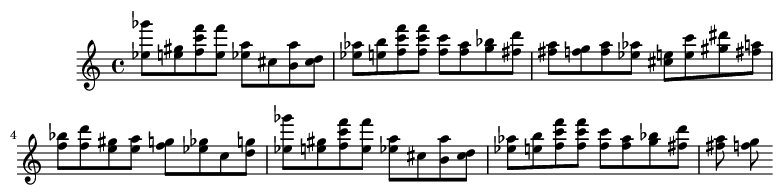

In [ ]:
show(generated_midi)

In [ ]:
play(generated_midi)

### 7 notes generation

### Encode basic 7 notes

In [ ]:
print(ENCODER[str(note.Note('G5').pitch.ps)])
print(ENCODER[str(note.Note('E5').pitch.ps)])
print(ENCODER[str(note.Note('D5').pitch.ps)])
print(ENCODER[str(note.Note('C5').pitch.ps)])

1057
1028
1010
984


In [ ]:
melody = np.array([1057, 1028, 1028, 1057, 1010, 1010, 984, 1028])
durations = np.array([12, 12, 12, 12, 12, 12, 12, 12])

In [ ]:
melody

array([1057, 1028, 1028, 1057, 1010, 1010,  984, 1028])

In [ ]:
X_set_notes_test[0]

array([1057, 1057, 1037, 1037,  968,  968, 1037, 1037])

In [ ]:
predicted_note = make_predictions(model_notes, tf.expand_dims(X_set_notes_test[0], axis=0))
predicted_note

1/1 [==============================] - 0s 20ms/step


1025.6284

In [ ]:
predicted_note = make_predictions(model_notes, tf.expand_dims(melody[-WINDOW_SIZE:], axis=0))
predicted_note

998.1158

### Create 100 new sounds based on the first 8

In [ ]:
melody_new = np.copy(melody)
durations_new = np.copy(durations)

for _ in range(100):
  predicted_note = make_predictions(model_notes, tf.expand_dims(melody_new[-WINDOW_SIZE:], axis=0))
  predicted_len = make_predictions(model_lens, tf.expand_dims(durations_new[-WINDOW_SIZE:], axis=0))
  melody_new  = np.append(melody_new , [predicted_note])
  durations_new = np.append(durations_new, [predicted_len])

In [ ]:
notes_list = round_and_convert(melody_new, max_note)
lens_list = round_and_convert(durations_new, max_len)

In [ ]:
generated_piece = decode_part(notes_list, lens_list, DECODER)

In [ ]:
melody_generated = create_midi_part(generated_piece)
generated_midi = stream.Stream(melody_generated)

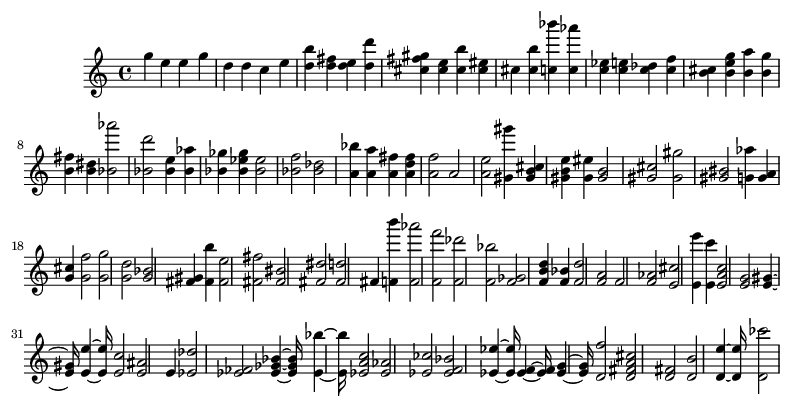

In [ ]:
show(generated_midi)

In [ ]:
play(generated_midi)